## Project Overview

This project utilizes Yellow Cab data, provided by the  NYC Taxi and Limousine Commission, to predict three different parameters:

1. Total  Fare prediction - Total Amount
2. Elapsed time (ride duration) prediction 
3. "Trip combination" traffic volume 

The data can be found at https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page, with the Yellow Cab data dictionary available at https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf.

In [1]:
# Import packages
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
import pyspark.sql.functions as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sc = SparkContext('local')
spark = SparkSession(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/07 14:33:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from sklearn.metrics import r2_score
import numpy as np
def plot_regression(df, target, prediction, title):
 
    df['resd']=np.round(df[prediction] - df[target], 4)
    df = df.sort_values(target, ascending=True)
 
    y_test=df[target]
    y_residual=df['resd']
    y_pred = df[prediction]
 
    fig, ax = plt.subplots(figsize=(7,5))
    scatter = ax.scatter(x=y_test, y=y_pred, c=y_residual, cmap="RdYlGn", marker="o", alpha=0.5, label='Predicted')
    cbar = plt.colorbar(scatter)
    cbar.ax.set_ylabel("Residual", rotation=90, fontsize=12)
 
    ax.plot([np.min(y_test), np.max(y_test)], [np.min(y_test), np.max(y_test)], "g--", alpha=0.75, linewidth=3, label='True')
    ax.set_xlabel("Actual", fontsize=12); 
    ax.set_ylabel("Predicted", fontsize=12); 
    ax.legend(loc='best')
    R_squared = r2_score(y_test, y_pred) 
 
    ax.set_title(title, fontsize=14)
    #additional text at the corner 
    plt.figtext(0.4,0.82,"$R^{2}$ = "+str(np.round(R_squared, 3)), fontsize=12, horizontalalignment="center",backgroundcolor=(0,0,0,0.4),color="w")

In [3]:
# Read data
file = "/Users/PengHao/Study/uwaterloo/BigData/groupAssignment/dataAndDesc/yellow_tripdata_2022-03.parquet" 
#"/Users/PengHao/Study/uwaterloo/BigData/groupAssignment/dataAndDesc/yellow_tripdata_2022-03.parquet"
df = spark.read.parquet(file, header = True, inferSchema = True)

In [4]:
df.createOrReplaceTempView("df")

## Data Clean and Feature Engineering

In [5]:
# Print df schema
df.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



In [6]:
# Drop missing values from dataframe
df = df.na.drop()

In [7]:
# Drop  duplicates from dataframe
df = df.dropDuplicates()

In [8]:
# Create new feature reflecting elapsed trip times (in seconds)
df = df.withColumn("elapsed_time", (df["tpep_dropoff_datetime"].cast("long")-df["tpep_pickup_datetime"].cast("long")))

# Create column indicating the day of week of the pickup
df = df.withColumn("day_of_week", F.dayofweek("tpep_pickup_datetime"))

# Create column indicating the hour of the pickup
df = df.withColumn("hour", F.hour("tpep_pickup_datetime"))

In [9]:
# Filter out any rows where tpep_dropoff_datetime is less than tpep_pickup_datetime and trips are < 3 hrs (10,800 seconds)
df = df.where((df.tpep_dropoff_datetime > df.tpep_pickup_datetime) & (df.elapsed_time < 10800))

In [10]:
# Columns to drop from PySpark dataframe and pandas dataframe
# Drop Store_and_fwd_flag: only provides information as to type of memory to store the trip data (in vehicle or server)
# Drop all fare/cost data other than total_amount to avoid information leakeage as this data is not known prior to the trip
# Drop tpep_dropoff_datetime as we have pickup time and elapsed time
drop_cols = ["tpep_pickup_datetime", "tpep_dropoff_datetime", "store_and_fwd_flag", "payment_type", "fare_amount", "extra",
             "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", "congestion_surcharge", "airport_fee"]

In [11]:
# Drop dropCols from PySpark dataframe
df = df.drop(*drop_cols)

In [12]:
# Create new column trip combining tuple combinations of PULocationID and DOLocationID
df = df.withColumn("trip", F.concat(F.col("PULocationID"), F.lit("_"), F.col("DOLocationID")))

In [13]:
# For One-Hot_Encoding we will need to reduce the number of trip categories to manage the size of the dataframe
# Filter dataframe for trip frequencies > threshold
trip_freq_threshold = 8000
mask = df.groupBy("trip").count().where(F.col("count") > trip_freq_threshold)
print("Number of trips > " +str(trip_freq_threshold)+ " is: " + str(mask.count()))
filtered_trips = [data[0] for data in mask.select('trip').collect()]
filtered_trips

OpenJDK 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
OpenJDK 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=22873Kb max_used=22879Kb free=108198Kb
 bounds [0x0000000106c54000, 0x00000001082d4000, 0x000000010ec54000]
 total_blobs=8715 nmethods=7734 adapters=892
 compilation: disabled (not enough contiguous free space left)


Number of trips > 8000 is: 13


['236_236',
 '237_237',
 '237_236',
 '141_236',
 '236_237',
 '237_161',
 '264_264',
 '161_236',
 '161_237',
 '239_142',
 '239_238',
 '236_161',
 '142_239']

In [14]:
# Filter df for values only in filtered_trips list
df = df.where(df.trip.isin(filtered_trips))

In [15]:
# Outlier removal - we'll filter out any total_amount > 500
# According to new york taxi fare webpage, initial charge would be 3.00
# https://www.nyc.gov/site/tlc/passengers/taxi-fare.page
df = df.where((df.total_amount > 3) & (df.total_amount < 500))

In [16]:
# Find dimensions of data after filtering elapsed times and trip frequencies
print("Dimensions of dataframe is now:")
print(df.count(), len(df.columns))

Dimensions of dataframe is now:


162945 11


## Data Exploratory and Feature Engineer for Fare Prediction

In [17]:
# Based on the NYC metadata, 0.0 is not a valid ratecode
# https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf
from pyspark.sql.functions import count,desc
rate_code_counts = df.groupBy('RatecodeID') \
                           .agg(count('*').alias('count')) \
                           .orderBy(desc('count'))

rate_code_counts.show()

+----------+------+
|RatecodeID| count|
+----------+------+
|       1.0|160425|
|       5.0|  1552|
|       2.0|   881|
|       3.0|    80|
|      99.0|     5|
|       4.0|     2|
+----------+------+



In [18]:
# rate code 99 is not a valid code, remove the invalid rows
from pyspark.sql.functions import col

# Create a list of values to filter on
ratecodes = ['1.0', '2.0', '3.0', '4.0', '5.0', '6.0']

# Filter the DataFrame to include only rows where RatecodeID is in the list of ratecodes
df = df.where(col('RatecodeID').isin(ratecodes))
print(df.count(), len(df.columns))

162940 11


In [19]:
# Check to see if any invalid value in trip distance and elapsed time columns
df.select('trip_distance', 'elapsed_time').describe().show()

+-------+------------------+-----------------+
|summary|     trip_distance|     elapsed_time|
+-------+------------------+-----------------+
|  count|            162940|           162940|
|   mean|1.3061547809009346|491.9583036700626|
| stddev|1.6513811324184393|381.0713814746734|
|    min|               0.0|                1|
|    max|             59.85|             9416|
+-------+------------------+-----------------+



In [20]:
df.where((col("trip_distance") <= 0) | (col("elapsed_time") <= 60)).count()

3692

In [21]:
# Drop the rows with negative trip_distance or duration is smaller than 1 min
df = df.where((df.trip_distance > 0) & (df.elapsed_time > 60))
print(df.count(), len(df.columns))

159248 11


In [22]:
# Create a new column to indicate if the day is weekday or weekend
from pyspark.sql.functions import when

df = df.withColumn("is_weekday", when((df.day_of_week >= 2) & (df.day_of_week <= 6), 1).otherwise(0))

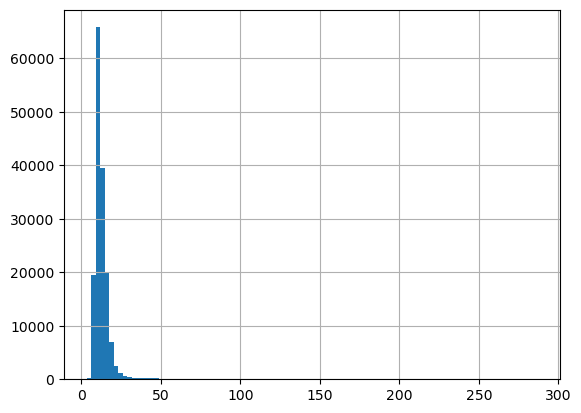

In [23]:
# Convert it to pandas and check the total_amount histogram
df_pandas = df.toPandas()

df_pandas["total_amount"].hist(bins = 100)
import matplotlib.pyplot as plt
plt.show()

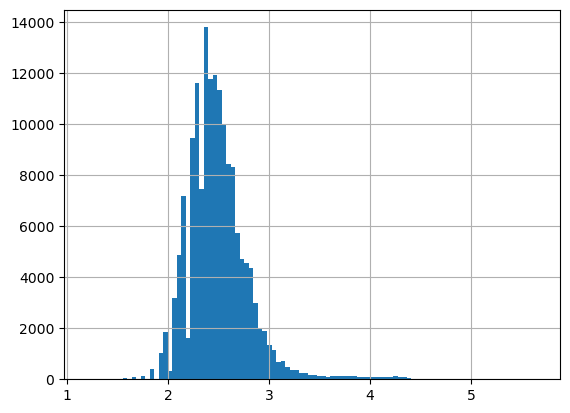

In [24]:
# By checking the above histogram, noted the total_amount has a long tail
# Try to use log transformation to see if the data could be better normorlized
from pyspark.sql.functions import log
df = df.withColumn("log_total_amount", log("total_amount"))

df_pandas = df.toPandas()
df_pandas["log_total_amount"].hist(bins = 100)

plt.show()

In [25]:
# Drop the columns that are duplicate or might not be useful in prediction
#drop_cols = ["VendorID", "passenger_count", "PULocationID", "DOLocationID", "RatecodeID"]
drop_cols = ["VendorID", "passenger_count", "PULocationID", "DOLocationID", "RatecodeID", "trip_distance", "elapsed_time"]
df1 = df.drop(*drop_cols)

# Data with log transformation are more normalized. Hence, drop the total_amount


In [26]:
drop_cols = ["total_amount"]
df1 = df1.drop(*drop_cols)

In [27]:
df1.printSchema()

root
 |-- day_of_week: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- trip: string (nullable = true)
 |-- is_weekday: integer (nullable = false)
 |-- log_total_amount: double (nullable = true)



## Data Transformation

In [28]:
from pyspark.ml.feature import StringIndexer,OneHotEncoder,StandardScaler
from pyspark.ml import Pipeline

cat_string_columns = ["trip"]
cat_columns = ["trip_index", "is_weekday", "day_of_week", "hour"]
discrete_columns = ["trip_distance","elapsed_time"]

# Create string indexer to convert trip and is_weekday column from string to numeric
string_indexer = StringIndexer(inputCol="trip", outputCol="trip_index")

# Create onehot encoder to convert into sparse vector 
encoder = [OneHotEncoder(inputCol=column, outputCol=column+"_ohe") for column in cat_columns]

# Create a pipeline for transform the data
pipeline = Pipeline(stages=[string_indexer, *encoder])

pipeline_transformer = pipeline.fit(df)

pipeline_transformer.write().overwrite().save("pipelinetransformer")

In [29]:
df_transform1 = pipeline_transformer.transform(df1).drop(*(cat_string_columns + cat_columns))

In [30]:
df_transform1.show(10)

+------------------+---------------+--------------+---------------+--------------+
|  log_total_amount| trip_index_ohe|is_weekday_ohe|day_of_week_ohe|      hour_ohe|
+------------------+---------------+--------------+---------------+--------------+
|2.6871669901857858|(12,[11],[1.0])|     (1,[],[])|  (7,[3],[1.0])|(23,[0],[1.0])|
|2.5447466501440172| (12,[5],[1.0])|     (1,[],[])|  (7,[3],[1.0])|(23,[2],[1.0])|
| 2.731766727719526|     (12,[],[])|     (1,[],[])|  (7,[3],[1.0])|(23,[2],[1.0])|
| 2.841998173611949|     (12,[],[])|     (1,[],[])|  (7,[3],[1.0])|(23,[3],[1.0])|
| 2.876948737564024|     (12,[],[])|     (1,[],[])|  (7,[3],[1.0])|(23,[4],[1.0])|
| 2.760009940032921| (12,[5],[1.0])|     (1,[],[])|  (7,[3],[1.0])|(23,[3],[1.0])|
|2.8425810940598164|(12,[11],[1.0])|     (1,[],[])|  (7,[3],[1.0])|(23,[6],[1.0])|
| 2.464703942470481| (12,[9],[1.0])|     (1,[],[])|  (7,[3],[1.0])|(23,[6],[1.0])|
|2.7763317085186157| (12,[1],[1.0])|     (1,[],[])|  (7,[3],[1.0])|(23,[6],[1.0])|
| 2.

## Pull features into vector

In [31]:
from pyspark.ml.feature import VectorAssembler

def generate_vector(df_after_transform):
    featureCols = [c for c in df_after_transform.columns if c != 'log_total_amount']
    print(featureCols)
    feature = VectorAssembler(inputCols=featureCols,outputCol="features")
    feature_vector= feature.transform(df_after_transform)
    return feature_vector

In [32]:
feature_vector1 = generate_vector(df_transform1)
feature_vector1.show()

['trip_index_ohe', 'is_weekday_ohe', 'day_of_week_ohe', 'hour_ohe']


+------------------+---------------+--------------+---------------+---------------+--------------------+
|  log_total_amount| trip_index_ohe|is_weekday_ohe|day_of_week_ohe|       hour_ohe|            features|
+------------------+---------------+--------------+---------------+---------------+--------------------+
|2.6871669901857858|(12,[11],[1.0])|     (1,[],[])|  (7,[3],[1.0])| (23,[0],[1.0])|(43,[11,16,20],[1...|
|2.5447466501440172| (12,[5],[1.0])|     (1,[],[])|  (7,[3],[1.0])| (23,[2],[1.0])|(43,[5,16,22],[1....|
| 2.731766727719526|     (12,[],[])|     (1,[],[])|  (7,[3],[1.0])| (23,[2],[1.0])|(43,[16,22],[1.0,...|
| 2.841998173611949|     (12,[],[])|     (1,[],[])|  (7,[3],[1.0])| (23,[3],[1.0])|(43,[16,23],[1.0,...|
| 2.876948737564024|     (12,[],[])|     (1,[],[])|  (7,[3],[1.0])| (23,[4],[1.0])|(43,[16,24],[1.0,...|
| 2.760009940032921| (12,[5],[1.0])|     (1,[],[])|  (7,[3],[1.0])| (23,[3],[1.0])|(43,[5,16,23],[1....|
|2.8425810940598164|(12,[11],[1.0])|     (1,[],[])|  (7

## Split the data into training and test set

In [33]:
def split_data(feature_vector):
    (trainingData, testData) = feature_vector.randomSplit([0.8, 0.2],seed = 42)
    return trainingData, testData

In [34]:
trainingData1, testData1 = split_data(feature_vector1)

## Model Prediction - Gradient Boosted Trees

In [35]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import exp

def gbt_model_predict(trainingData, testData, name):
    # create a GBTRegressor object
    gbt = GBTRegressor(featuresCol='features', labelCol='log_total_amount', maxIter=10)

    # fit the model to the training data
    gbt_model = gbt.fit(trainingData)

    # make predictions on the test data
    gbt_predictions = gbt_model.transform(testData)
    gbt_predictions.select("prediction", "log_total_amount", "features").show()
    
    # evaluate the model using RMSE
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="log_total_amount", predictionCol="prediction")
    rmse = evaluator.evaluate(gbt_predictions)
    
    print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
    
    gbt_predictions = gbt_predictions.withColumn('predicted_total_amount', exp('prediction'))
    
    df_holdout = gbt_predictions.select("prediction","log_total_amount").toPandas()
    plot_regression(df_holdout, "log_total_amount", 'prediction', name)
    return gbt_predictions

23/04/07 14:35:36 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/04/07 14:35:36 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
+------------------+------------------+--------------------+
|        prediction|  log_total_amount|            features|
+------------------+------------------+--------------------+
|2.7641035895451798|  1.33500106673234|(43,[2,17,27],[1....|
| 2.772318589509443|  1.33500106673234|(43,[2,18,27],[1....|
| 2.760191752911584|  1.33500106673234|(43,[2,12,42],[1....|
|2.7558808108650354|1.4586150226995167|(43,[2,15,40],[1....|
| 2.772318589509443|1.4586150226995167|(43,[2,18,24],[1....|
| 2.760191752911584|1.4586150226995167|(43,[2,19,20],[1....|
| 2.760191752911584|1.4586150226995167|(43,[2,12,14,30],...|
|2.7558808108650354|1.5686159179138452|(43,[2,15,22],[1....|
|2.7641035895451798|1.5686159179138452|(43,[2,17,23],[1....|
|2.7641035895451798|1.

Root Mean Squared Error (RMSE) on test data = 0.267269


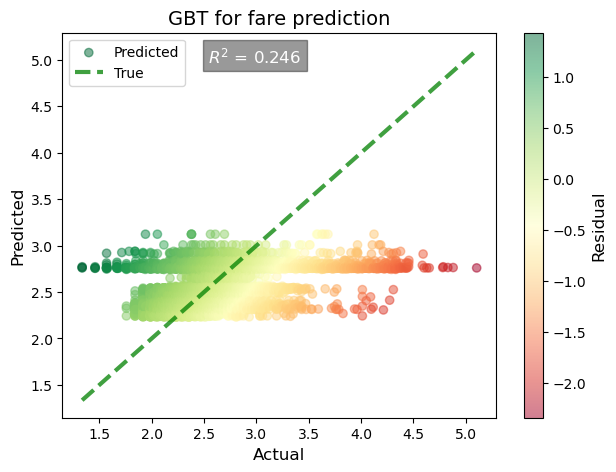

In [36]:
gbt_predictions1=gbt_model_predict(trainingData1, testData1, "GBT for fare prediction")
#gbt_predictions1.select("prediction", "log_total_amount","predicted_total_amount", "features").show()

As we can see from the plotting, the R-square is small which means the model is not able to explain a large portion of the variance in the data. We will try to find if any outliers we should remove.

In [37]:
def get_residual_plot(gbt_predictions):
    # get the predicted values and actual values from the GBTRegressor predictions DataFrame
    predicted = np.array(gbt_predictions.select("prediction").rdd.map(lambda x: x[0]).collect())
    actual = np.array(gbt_predictions.select("log_total_amount").rdd.map(lambda x: x[0]).collect())

    # calculate the residuals
    residuals = actual - predicted

    # create the residual plot
    fig, ax = plt.subplots()
    ax.scatter(predicted, residuals, alpha=0.5)
    ax.axhline(y=0, color='black', linestyle='--')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Residuals')
    ax.set_title('Residual Plot for GBTRegressor Model')
    plt.show()

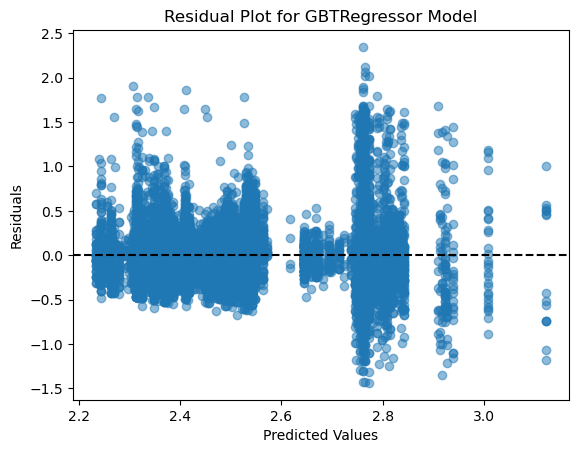

In [38]:
get_residual_plot(gbt_predictions1)

Based on the residual plot, we will try to remove the rows that has the upper bound residual for 1.0 and lower bound for -1.0

In [39]:
from pyspark.sql.functions import col
def remove_outlier(gbt_predictions, upperbound, lowerbound, name):
    # create a new DataFrame with residuals
    residuals = gbt_predictions.select("prediction", "log_total_amount") \
                .withColumn("residuals", col("log_total_amount") - col("prediction"))

    # calculate the IQR
    q1 = residuals.approxQuantile("residuals", [0.25], 0.05)[0]
    q3 = residuals.approxQuantile("residuals", [0.75], 0.05)[0]
    iqr = q3 - q1

    # define the upper and lower bounds for outliers
    upper_bound = q3 + upperbound * iqr
    lower_bound = q1 - lowerbound * iqr

    # filter out the rows with outliers
    residuals_filtered = residuals.filter((col("residuals") <= upper_bound) & (col("residuals") >= lower_bound))

    # show the resulting DataFrame
    #residuals_filtered.show()
    
    df_no_outlier = residuals_filtered.select("prediction","log_total_amount").toPandas()
    plot_regression(df_no_outlier, 'log_total_amount', 'prediction', name)

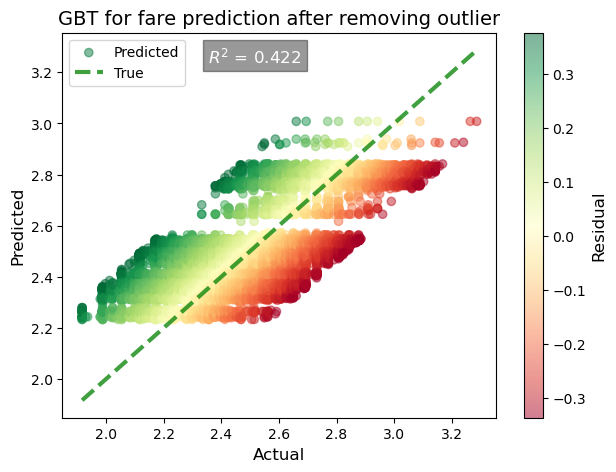

In [40]:
remove_outlier(gbt_predictions1, 1.0, 1.0, "GBT for fare prediction after removing outlier")

The result after removing the outlier seems still not perform very well, we revisited the features we selected. We decided to add on trip_distance as a feature (The estimated distance could be calculated from google map)

## Model Prediction - Update the feature set to include trip_distance as part of the feature

In [41]:
# Prepare the new feature set with trip_distance
drop_cols2 = ["VendorID", "passenger_count", "PULocationID", "DOLocationID", "RatecodeID", "elapsed_time", "total_amount"]
df2 = df.drop(*drop_cols2)
df2.printSchema()

root
 |-- trip_distance: double (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- trip: string (nullable = true)
 |-- is_weekday: integer (nullable = false)
 |-- log_total_amount: double (nullable = true)



In [42]:
# Transform the data
df_transform2 = pipeline_transformer.transform(df2).drop(*(cat_string_columns + cat_columns))
df_transform2.show(10)

+-------------+------------------+---------------+--------------+---------------+--------------+
|trip_distance|  log_total_amount| trip_index_ohe|is_weekday_ohe|day_of_week_ohe|      hour_ohe|
+-------------+------------------+---------------+--------------+---------------+--------------+
|         1.72|2.6871669901857858|(12,[11],[1.0])|     (1,[],[])|  (7,[3],[1.0])|(23,[0],[1.0])|
|         0.83|2.5447466501440172| (12,[5],[1.0])|     (1,[],[])|  (7,[3],[1.0])|(23,[2],[1.0])|
|          2.4| 2.731766727719526|     (12,[],[])|     (1,[],[])|  (7,[3],[1.0])|(23,[2],[1.0])|
|          1.9| 2.841998173611949|     (12,[],[])|     (1,[],[])|  (7,[3],[1.0])|(23,[3],[1.0])|
|         2.09| 2.876948737564024|     (12,[],[])|     (1,[],[])|  (7,[3],[1.0])|(23,[4],[1.0])|
|         1.74| 2.760009940032921| (12,[5],[1.0])|     (1,[],[])|  (7,[3],[1.0])|(23,[3],[1.0])|
|         2.03|2.8425810940598164|(12,[11],[1.0])|     (1,[],[])|  (7,[3],[1.0])|(23,[6],[1.0])|
|         1.21| 2.464703942470

In [43]:
feature_vector2 = generate_vector(df_transform2)
feature_vector2.show()
trainingData2, testData2 = split_data(feature_vector2)

['trip_distance', 'trip_index_ohe', 'is_weekday_ohe', 'day_of_week_ohe', 'hour_ohe']


+-------------+------------------+---------------+--------------+---------------+---------------+--------------------+
|trip_distance|  log_total_amount| trip_index_ohe|is_weekday_ohe|day_of_week_ohe|       hour_ohe|            features|
+-------------+------------------+---------------+--------------+---------------+---------------+--------------------+
|         1.72|2.6871669901857858|(12,[11],[1.0])|     (1,[],[])|  (7,[3],[1.0])| (23,[0],[1.0])|(44,[0,12,17,21],...|
|         0.83|2.5447466501440172| (12,[5],[1.0])|     (1,[],[])|  (7,[3],[1.0])| (23,[2],[1.0])|(44,[0,6,17,23],[...|
|          2.4| 2.731766727719526|     (12,[],[])|     (1,[],[])|  (7,[3],[1.0])| (23,[2],[1.0])|(44,[0,17,23],[2....|
|          1.9| 2.841998173611949|     (12,[],[])|     (1,[],[])|  (7,[3],[1.0])| (23,[3],[1.0])|(44,[0,17,24],[1....|
|         2.09| 2.876948737564024|     (12,[],[])|     (1,[],[])|  (7,[3],[1.0])| (23,[4],[1.0])|(44,[0,17,25],[2....|
|         1.74| 2.760009940032921| (12,[5],[1.0]

+------------------+------------------+--------------------+
|        prediction|  log_total_amount|            features|
+------------------+------------------+--------------------+
|1.9682351552466122|1.7578579175523736|(44,[0,3,18,23],[...|
|2.1259384572298368| 1.916922612182061|(44,[0,4,20,25],[...|
|2.1339538260736752| 2.505525936990736|(44,[0,1,20,39],[...|
|   2.1166413695485|1.7578579175523736|(44,[0,5,16,26],[...|
|2.1700926530977513|2.3570732782781154|(44,[0,9,18,33],[...|
|2.1410534419440417| 1.840549633397487|(44,[0,4,19,29],[...|
|2.1353648901332813|1.9878743481543455|(44,[0,5,19,35],[...|
| 2.066859574066525| 1.840549633397487|(44,[0,4,13,15,28...|
|2.1373364143101083| 1.840549633397487|(44,[0,4,17,31],[...|
| 2.131096289517835| 1.840549633397487|(44,[0,5,17,32],[...|
|2.1353648901332813| 1.840549633397487|(44,[0,5,19,29],[...|
|2.1159867668326924| 2.063058062429312|(44,[0,4,19,24],[...|
| 2.057900341974879|2.1162555148025524|(44,[0,3,19,35],[...|
|2.0655030637796763|2.54

Root Mean Squared Error (RMSE) on test data = 0.153788


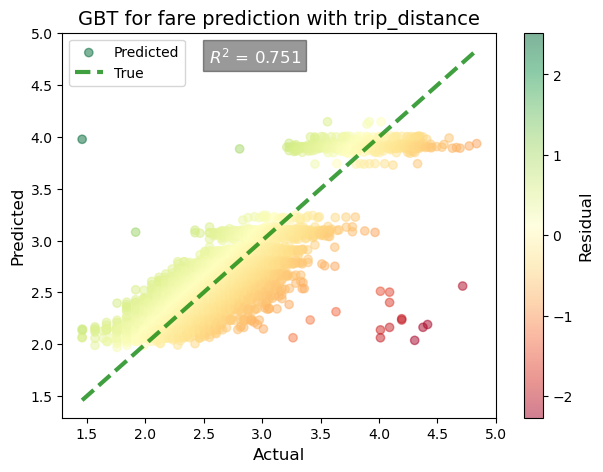

In [44]:
# Predict with GBT model with trip_distance
gbt_predictions2=gbt_model_predict(trainingData2, testData2, "GBT for fare prediction with trip_distance")

With trip_distance, the R-square looks much better than the one without trip_distance

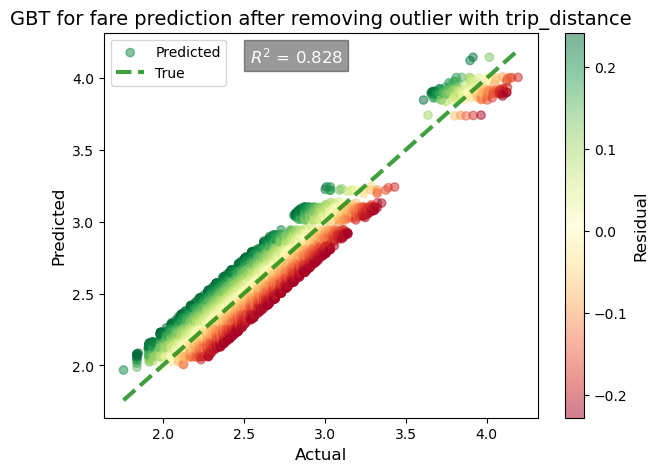

In [45]:
# Try to remove the outlier
remove_outlier(gbt_predictions2, 1.0, 1.0,"GBT for fare prediction after removing outlier with trip_distance")

In [46]:
spark.stop()

### In conclusion, the feature set with trip_distance performs better than the model without trip_distance for fare prediction